In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_CHLR1.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 01:30:00    69.938004
2013-03-20 01:45:00    70.250000
2013-03-20 02:00:00    70.563004
2013-03-20 02:15:00    70.813004
2013-03-20 02:30:00    71.125000
2013-03-20 02:45:00    71.563004
2013-03-20 03:00:00    71.813004
2013-03-20 03:15:00    72.125000
2013-03-20 03:30:00    72.563004
2013-03-20 03:45:00    72.750000
2013-03-20 04:00:00    73.188004
2013-03-20 04:15:00    73.500000
2013-03-20 04:30:00    73.813004
2013-03-20 04:45:00    74.188004
2013-03-20 05:00:00    74.438004
2013-03-20 05:15:00    74.688004
2013-03-20 05:30:00    75.063004
2013-03-20 05:45:00    75.313004
2013-03-20 06:00:00    75.688004
2013-03-20 06:15:00    75.875000
2013-03-20 06:30:00    76.125000
2013-03-20 06:45:00    76.438004
2013-03-20 07:00:00    76.750000
2013-03-20 07:15:00    77.063004
2013-03-20 07:30:00    77.375000
2013-03-20 07:45:00    77.563004
2013-03-20 08:00:00    77.750000
2013-03-20 08:15:00    78.125000
2013-03-20 08

b'Skipping line 25740: expected 7 fields, saw 8\nSkipping line 25741: expected 7 fields, saw 8\nSkipping line 25742: expected 7 fields, saw 8\nSkipping line 25743: expected 7 fields, saw 8\nSkipping line 25744: expected 7 fields, saw 8\nSkipping line 25745: expected 7 fields, saw 8\nSkipping line 25746: expected 7 fields, saw 8\nSkipping line 25747: expected 7 fields, saw 8\nSkipping line 25748: expected 7 fields, saw 8\nSkipping line 25749: expected 7 fields, saw 8\nSkipping line 25750: expected 7 fields, saw 8\nSkipping line 25751: expected 7 fields, saw 8\nSkipping line 25752: expected 7 fields, saw 8\nSkipping line 25753: expected 7 fields, saw 8\nSkipping line 25754: expected 7 fields, saw 8\nSkipping line 25755: expected 7 fields, saw 8\nSkipping line 25756: expected 7 fields, saw 8\nSkipping line 25757: expected 7 fields, saw 8\nSkipping line 25758: expected 7 fields, saw 8\nSkipping line 25759: expected 7 fields, saw 8\nSkipping line 25760: expected 7 fields, saw 8\nSkipping li

In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                34969
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -35279.748
Method:                           css   S.D. of innovations              0.664
Date:                Mon, 20 Jul 2015   AIC                          70563.495
Time:                        13:38:05   BIC                          70580.420
Sample:                    03-20-2013   HQIC                         70568.887
                         - 03-19-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0001      0.004      0.031      0.975        -0.007     0.007


We see that ARIMA is not currently fitting the time series data. We look for
an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    34969.000000
mean         0.000002
std          0.010879
min         -0.261286
5%          -0.003902
50%          0.000000
95%          0.003939
max          0.163268
Name: steam values, dtype: float64


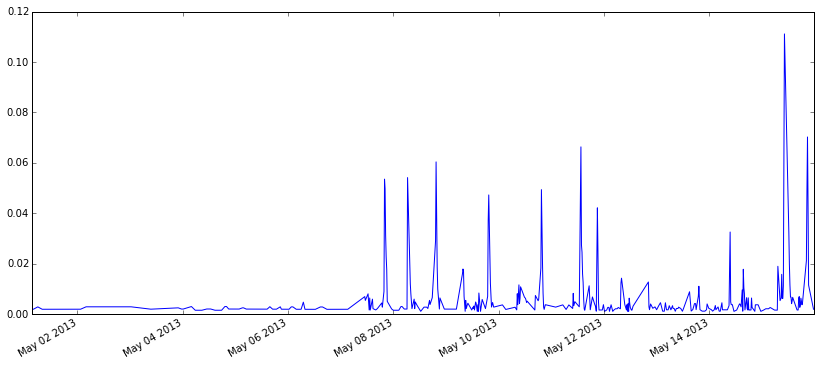

In [3]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
print(park_ts_logr.describe(percentiles=[0.05, 0.95]))

park_ts_logr[(park_ts_logr > 0.001) & (park_ts_logr < 0.23)][
'2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

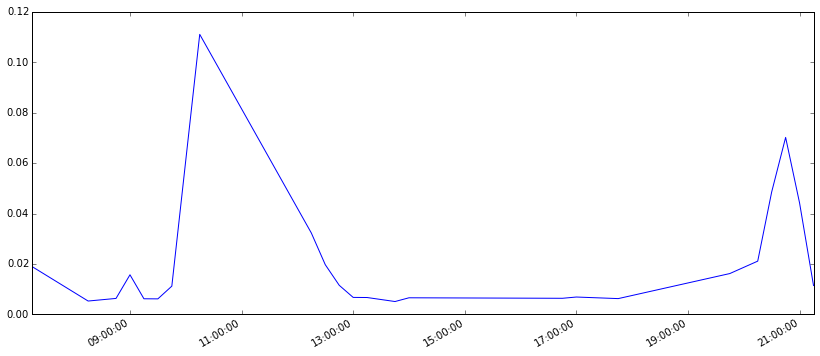

In [4]:
park_ts_logr[(park_ts_logr > 0.005) & (park_ts_logr < 0.18)][
'2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                1072.411
Date:                            Mon, 20 Jul 2015   AIC                          -2140.822
Time:                                    13:38:07   BIC                          -2132.475
Sample:                                05-06-2013   HQIC                         -2137.541
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2719      0.047      5.810      0.000         0.180     0.364
sigma2         0.0002   1.55e-05     14.173      0.000         0.000     0.000


While the fit isn't terrible, it can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of chilled water temperature dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [6]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  155
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 176.275
Date:                            Mon, 20 Jul 2015   AIC                           -348.550
Time:                                    13:38:09   BIC                           -342.464
Sample:                                05-06-2013   HQIC                          -346.078
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.6639      0.076      8.714      0.000         0.515     0.813
sigma2         0.0002   3.01e-05      5.408      0.000         0.000     0.000


Our data is clustered very close to the mean--i.e, the spikes are very small spikes. Consequently, the positive of filtering them out (i.e. smoothing the data) outweighs the drawback of reducing the number of points to fit. 

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1147
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                2440.612
Date:                            Mon, 20 Jul 2015   AIC                          -4877.224
Time:                                    13:38:13   BIC                          -4867.135
Sample:                                05-06-2013   HQIC                         -4873.415
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2736      0.028      9.935      0.000         0.220     0.328
sigma2         0.0006   2.56e-05     22.124      0.000         0.001     0.001


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3279
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                7144.206
Date:                            Mon, 20 Jul 2015   AIC                         -14284.412
Time:                                    13:38:18   BIC                         -14272.221
Sample:                                05-06-2013   HQIC                        -14280.047
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2326      0.016     14.223      0.000         0.201     0.265
sigma2         0.0007   1.57e-05     41.947      0.000         0.001     0.001


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood               21223.476
Date:                            Mon, 20 Jul 2015   AIC                         -42442.952
Time:                                    13:38:28   BIC                         -42428.716
Sample:                                05-06-2013   HQIC                        -42438.111
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1007      0.010      9.691      0.000         0.080     0.121
sigma2         0.0005   7.94e-06     66.820      0.000         0.001     0.001


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times together with the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [10]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1221
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                2768.297
Date:                            Mon, 20 Jul 2015   AIC                          -5532.594
Time:                                    13:40:03   BIC                          -5522.379
Sample:                                03-25-2013   HQIC                         -5528.749
                                     - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1541      0.029      5.365      0.000         0.098     0.210
sigma2         0.0004   1.87e-05     22.902      0.000         0.000     0.000
                                 Statespace Mod

Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4992
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               12932.390
Date:                            Mon, 20 Jul 2015   AIC                         -25860.780
Time:                                    13:40:26   BIC                         -25847.749
Sample:                                03-25-2013   HQIC                        -25856.212
                                     - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.0602      0.014      4.236      0.000         0.032     0.088
sigma2         0.0003   6.05e-06     49.224      0.000         0.000     0.000
                                 Statespace Mod

/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1086
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2621.017
Method:                           css   S.D. of innovations              0.022
Date:                Mon, 20 Jul 2015   AIC                          -5238.034
Time:                        13:41:34   BIC                          -5228.053
Sample:                    03-25-2013   HQIC                         -5234.256
                         - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -7.865e-07      0.001     -0.001      0.999        -0.001     0.001


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1086
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2689.219
Method:                           css   S.D. of innovations              0.020
Date:                Mon, 20 Jul 2015   AIC                          -5374.439
Time:                        13:41:34   BIC                          -5364.458
Sample:                    03-25-2013   HQIC                         -5370.660
                         - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -7.859e-07      0.001     -0.001      0.999        -0.001     0.001


Observe that the fit has improved, though not dramatically like for some of our other time series. This is due to Monday ramp-up values being very close to the mean. In general, our time series values are clustered very close together throughout the week. 